In [2]:
# # Importing PlaidML. Make sure you follow this order
# import plaidml.keras
# plaidml.keras.install_backend()
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# import pickle 
# import pandas as pd
# import numpy as np
# import math
# import random
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# %matplotlib inline

# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten
# from keras.layers import Conv2D, MaxPooling2D
# from keras import backend as K

# import tensorflow as tf
# from keras.preprocessing.image import ImageDataGenerator

In [37]:
from __future__ import division
# Load Libraries, Data and Set Seed
import pickle 
import pandas as pd
import numpy as np
import math
import random
import glob
import h5py
import imgaug as aug
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import io
import tensorflow as tf
# import ftfy
import nltk
import re
import csv
import os
import sys
import codecs
import json

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

## KAGGLE
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

# from gensim.models import KeyedVectors
# from sklearn.feature_extraction.text import CountVectorizer
# from nltk.corpus import stopwords
# from nltk import PorterStemmer
# from nltk import SnowballStemmer
# from keras.models import Model, Sequential
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

In [9]:
base_dir = 'chest_xray'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'test')


train_normal_dir = os.path.join(train_dir, 'NORMAL') # Directory with our training normal pictures
train_pneu_dir = os.path.join(train_dir, 'PNEUMONIA') # Directory with our training pneunomia pictures
validation_cats_dir = os.path.join(validation_dir, 'NORMAL') # Directory with our validation normal pictures
validation_dogs_dir = os.path.join(validation_dir, 'PNEUMONIA') # Directory with our validation pneunomia pictures

train_normal_fnames = os.listdir(train_normal_dir)
train_pneu_fnames = os.listdir(train_pneu_dir)

print(len(train_normal_fnames))
print(len(train_pneu_fnames))

# KAGGLE Plot the results 
# plt.figure(figsize=(10,8))
# sns.barplot(x=cases_count.index, y= cases_count.values)
# plt.title('Number of cases', fontsize=14)
# plt.xlabel('Case type', fontsize=12)
# plt.ylabel('Count', fontsize=12)
# plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
# plt.show()

1341
3875


In [11]:
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 20,
                                   width_shift_range = False,#0.2,
                                   height_shift_range = False,#0.2,
                                   brightness_range = (1.2, 1.5),
                                   shear_range = False,
                                   zoom_range = False,#0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 16,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 16,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


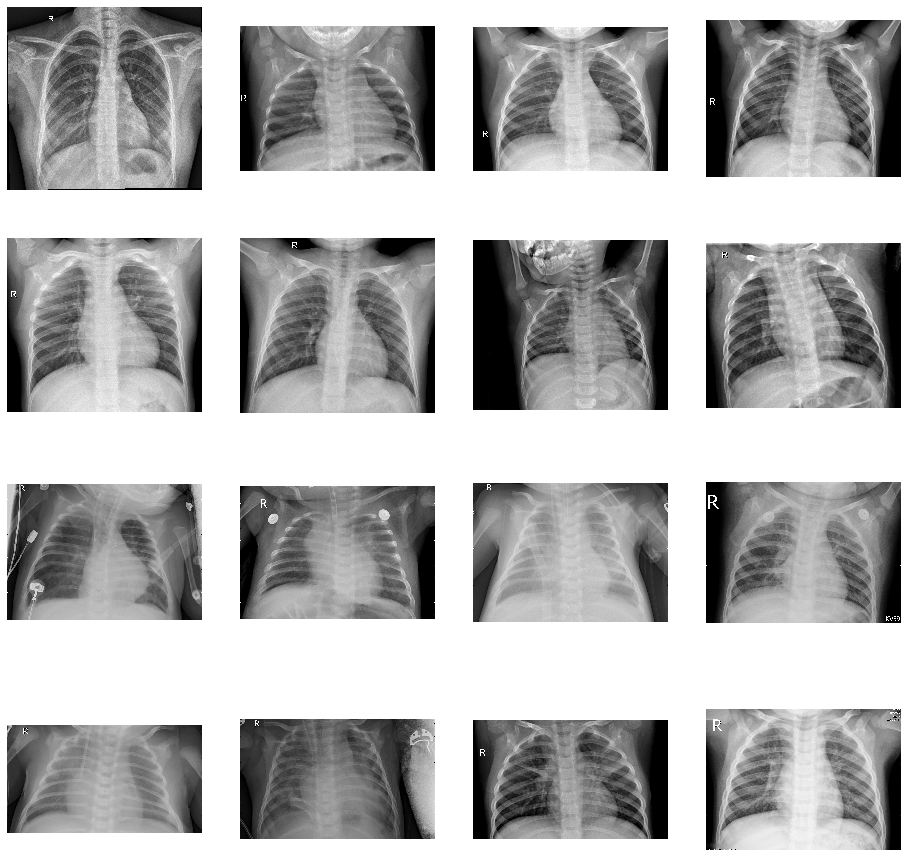

<Figure size 432x288 with 0 Axes>

In [12]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_normal_pix = [os.path.join(train_normal_dir, fname) for fname in train_normal_fnames[pic_index-8:pic_index]]
next_pneu_pix = [os.path.join(train_pneu_dir, fname) for fname in train_pneu_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_normal_pix+next_pneu_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    img = mpimg.imread(img_path)
    plt.imshow(img, cmap='gray')

plt.show()

# Adjust subplot parameters to give specified padding
plt.tight_layout()

In [51]:
def build_model():
    input_img = Input(shape=(150,150,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(64, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(1, activation='sigmoid', name='fc3')(x)
    #x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [52]:
model =  build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 150, 150, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 150, 150, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 150, 150, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 75, 75, 64)        0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 75, 75, 128)       8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 75, 75, 128)       17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 37, 37, 128)       0         
__________

In [53]:
# Open the VGG16 weight file
f = h5py.File('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 150, 150, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 150, 150, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 150, 150, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 75, 75, 64)        0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 75, 75, 128)       8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 75, 75, 128)       17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 37, 37, 128)       0         
__________

In [54]:
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [55]:
batch_size = 16
nb_epochs = 5

# # Get a train data generator
# train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# # Define the number of training steps
# nb_train_steps = train_data.shape[0]//batch_size

# print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

In [56]:
# Fit the model
history = model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=326,
                              validation_data=validation_generator, validation_steps=8,callbacks=[es, chkpt],
                              class_weight={0:1.0, 1:0.4})

Epoch 1/5
326/326 [==============================] - 2158s 7s/step - loss: 0.3533 - acc: 0.6944 - val_loss: 0.6410 - val_acc: 0.6484
Epoch 2/5
326/326 [==============================] - 2056s 6s/step - loss: 0.2052 - acc: 0.8487 - val_loss: 0.4826 - val_acc: 0.7578
Epoch 3/5
326/326 [==============================] - 1998s 6s/step - loss: 0.1563 - acc: 0.8953 - val_loss: 0.9022 - val_acc: 0.6250
Epoch 4/5
326/326 [==============================] - 2046s 6s/step - loss: 0.1338 - acc: 0.9109 - val_loss: 2.3116 - val_acc: 0.5781
Epoch 5/5
326/326 [==============================] - 2066s 6s/step - loss: 0.1261 - acc: 0.9078 - val_loss: 0.7801 - val_acc: 0.7578


In [5]:
model = keras.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    keras.layers.Conv2D(16, (16, 16), activation='relu', input_shape=(150, 150, 1)),
    keras.layers.MaxPooling2D(2, 2),
#     # The second convolution
#     tf.keras.layers.Conv2D(16, (16, 16), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    keras.layers.Conv2D(32, (16, 16), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
#     # The fourth convolution
#     tf.keras.layers.Conv2D(64, (16, 16), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # The fifth convolution
#     tf.keras.layers.Conv2D(128, (16, 16), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    keras.layers.Flatten(),
    # 512 neuron hidden layer
    keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    keras.layers.Dense(1, activation='sigmoid')
])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 135, 135, 16)      4112      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 67, 67, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        131104    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               11076096  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total para

In [38]:
# New on GPU
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=326,  
      epochs=5,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8) 

Instructions for updating:
Use tf.cast instead.
Epoch 1/5


ValueError: Error when checking target: expected fc3 to have shape (2,) but got array with shape (1,)

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=326,  
      epochs=5,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8) 

AttributeError: 'DirectoryIterator' object has no attribute 'ndim'

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=326,  
      epochs=5,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8) 

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
326/326 [==============================] - 613s 2s/step - loss: 4.0948 - acc: 0.7406 - val_loss: 5.9784 - val_acc: 0.6250
Epoch 2/5
326/326 [==============================] - 579s 2s/step - loss: 4.0987 - acc: 0.7429 - val_loss: 5.9784 - val_acc: 0.6250
Epoch 3/5
326/326 [==============================] - 447s 1s/step - loss: 4.0987 - acc: 0.7429 - val_loss: 5.9784 - val_acc: 0.6250
Epoch 4/5
326/326 [==============================] - 417s 1s/step - loss: 4.0987 - acc: 0.7429 - val_loss: 5.9784 - val_acc: 0.6250
Epoch 5/5
326/326 [==============================] - 418s 1s/step - loss: 4.0987 - acc: 0.7429 - val_loss: 5.9784 - val_acc: 0.6250


In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()